# Notebook created 17.02.2025


In [77]:
#imports to be used later on
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib.cm import get_cmap
from astropy.io import fits
import matplotlib
import scipy.ndimage
import scipy.interpolate
from astropy.table import Table
import astropy.units as u
%matplotlib inline

import math
import matplotlib.patches as patches

import random

# # gala
# import gala.coordinates as gc
# import gala.dynamics as gd
# import gala.potential as gp
# from gala.units import galactic
# import gala.integrate as gi
# from gala.units import galactic, UnitSystem

import astropy.coordinates as coord
from astropy.coordinates import SkyOffsetFrame 
from astropy.wcs import WCS
plt.ioff

from scipy.optimize import minimize

# import reproject

from scipy.interpolate import interp1d

# Default gala cosmology: # WMAP7 cosmology in effect
from astropy import cosmology
cosmo = cosmology.default_cosmology.get()


# # Import all the functions needed for fitting + stream generating etv
# import CenA_functions as CenA

In [78]:
#path = '/Users/hzg129/Desktop/Research2024/CENA/'
#plot_path = '/Users/spearson/Desktop/Research/CenA/CenA2021/plots/'

In [79]:
mpl.rcParams.update({'font.size': 20})
label_size = 20
mpl.rcParams['xtick.labelsize'] = 18#label_size 
mpl.rcParams['ytick.labelsize'] =18#label_size a

# Data 

In [80]:
#path = '/Users/spearson/Desktop/Research/CenA/'
hdulist = fits.open('CenA_rgbmap_msolpc2.fits')
hdulist.info()
hdulist[0].data
hdr = dict(hdulist[0].header)
image = hdulist[0].data
wcs_input_dict = hdulist[0].header
wcs_helix_dict = WCS(wcs_input_dict)
header = hdulist[0].header
wcs_helix = WCS(header)

#getting rid of 0's from image data for imshow lognorm to work
j = 0
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if image[i,j] == 0.:
            image[i,j] = 10**-10
            j = j+1

# j = 0
# for i in range(image.shape[0]):
#     for j in range(image.shape[1]):
#         if math.isnan(image[i,j]):
#             print('it is nan')
#             image[i,j] = 10**-10
#             j = j+1





Filename: CenA_rgbmap_msolpc2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   (456, 424)   float64   


In [81]:
image_fill = np.ones([426,456])*10**-10

# Plot data

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_1094170/1116115672.py:7: SyntaxWarning: invalid escape sequence '\o'
  plt.colorbar(label='M$_{\odot}$ pc$^{-2}$', shrink=0.75)


Text(401, 28, '30 kpc')

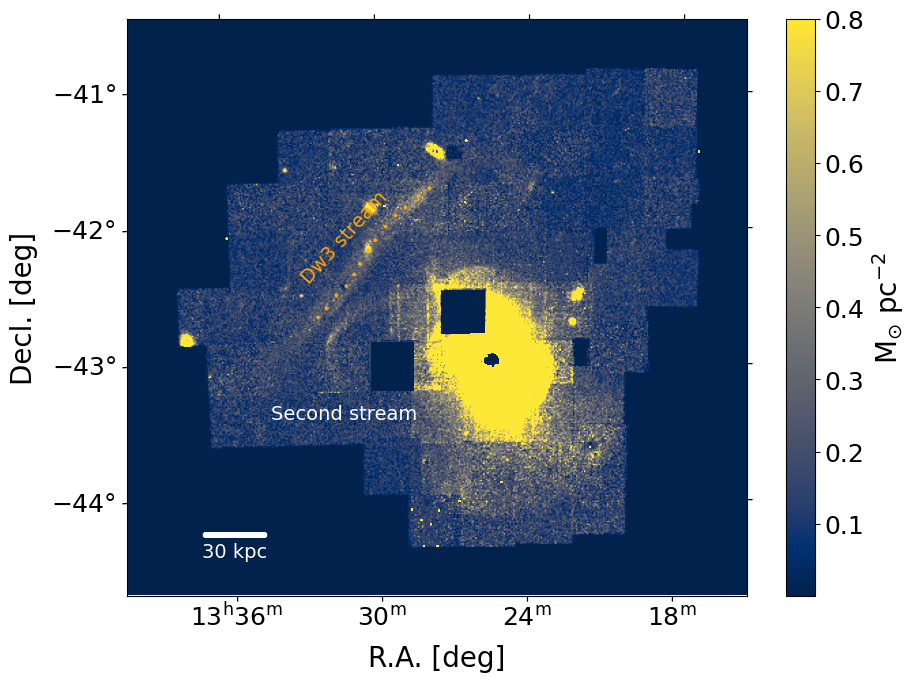

In [82]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_helix)
#plt.imshow(image_fill, origin='lower', cmap='cividis', norm=LogNorm(),vmin =0.01, vmax = 10, aspect='equal', rasterized=True)
plt.imshow(image, origin='lower', cmap='cividis',  aspect='equal', rasterized=True,vmin =0.00001, vmax = 0.8)
plt.xlabel(r'R.A. [deg]')
plt.ylabel(r'Decl. [deg]')
plt.colorbar(label='M$_{\odot}$ pc$^{-2}$', shrink=0.75)



control_points_new = coord.SkyCoord([203.1,\
    202.585167, 202.675, 202.735,202.816, 202.916, 203.016, \
                                 202.515, 202.415, 202.315, 202.215, 202.09,\
                                    201.98]*u.deg, \
                                [-42.68,\
    -42.191741,-42.29,-42.37, -42.45,-42.52,-42.61, \
                                 -42.12, -42.02, -41.94,  -41.88, -41.8,\
                                 -41.74,]*u.deg)


ra_err_new =  np.ones(len(control_points_new.ra.deg))*0.01
dec_err_new =  np.ones(len(control_points_new.dec.deg))*0.01
plt.errorbar(control_points_new.ra.deg, control_points_new.dec.deg,yerr=dec_err_new, xerr=None,\
             fmt='.', color='orange',markersize=4,alpha=0.7,ecolor='white',transform=ax.get_transform('icrs'), rasterized=True)

# plt.errorbar(control_SS.ra.deg, control_SS.dec.deg,yerr=0.01, xerr=None,\
#              fmt='.', color='white',markersize=4,alpha=0.7,ecolor='white',transform=ax.get_transform('icrs'), rasterized=True)




plt.text(350,130,'Second stream', rotation=0, size=14, color='white', rasterized=True)
plt.text(330,230,'Dw3 stream', rotation=47.76, size=14, color='orange', rasterized=True)

ax.set_ylim([0,424])
ax.set_xlim([456,0])

plt.fill_between([400,354],44,46, color='white', rasterized=True)
plt.text(401,28, '30 kpc', color='white', fontsize=14, rasterized=True)
    
#fig.tight_layout()
#fig.savefig(path + 'CenA2021/plots/Fig1_paper.pdf', dpi=300)


## Try changing your threshold and bin_factor to change spacing of the red points you will use as input to your data.

Changing the bin factor will also change the value in each pixel (try visualizing plt.imshow(rebinned_binary, origin='lower', cmap='binary', aspect='auto'))

In [83]:
threshold = 0.44
binary_mask = np.where(image > threshold, 1, 0)

In [282]:
bin_factor = 4  # Change this to control bin size - if you set it to one it should look like data above

y_size, x_size = binary_mask.shape
new_y, new_x = y_size // bin_factor, x_size // bin_factor


In [283]:
# Rebin the mask: sum over bin_factor × bin_factor regions
rebinned = binary_mask[:new_y * bin_factor, :new_x * bin_factor]  # Trim excess
rebinned = rebinned.reshape(new_y, bin_factor, new_x, bin_factor).sum(axis=(1, 3))

# Normalize to binary (1 if any value > 0 in bin)
rebinned_binary = np.where(rebinned > 0, 1, 0)

# Compute bin centers
x_centers = (np.arange(new_x) + 0.5) * bin_factor
y_centers = (np.arange(new_y) + 0.5) * bin_factor

# Find bin centers where rebinned_binary == 1
y_idx, x_idx = np.where(rebinned_binary == 1)
x_pts = x_centers[x_idx]
y_pts = y_centers[y_idx]



In [284]:
x_centers.shape[0]

114

## Now make 2dhistogram of only ones and zeros based on bin_factor and threshold above

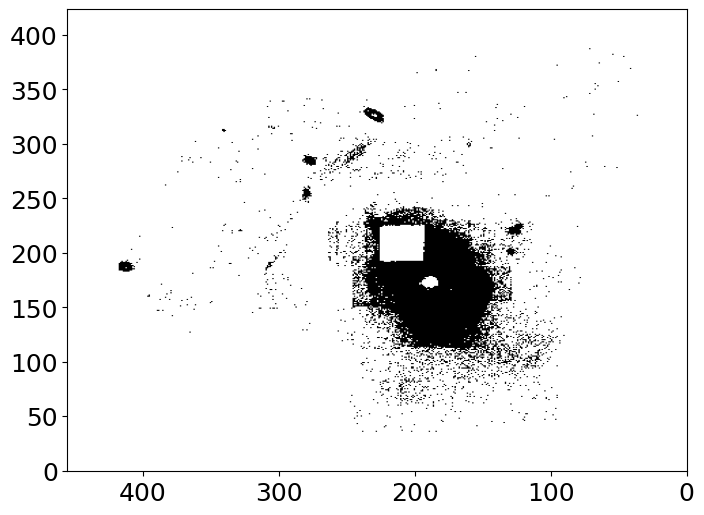

In [285]:
plt.figure(figsize=(8, 6))
plt.imshow(binary_mask, origin='lower', cmap='binary', aspect='auto')
#plt.imshow(rebinned_binary, origin='lower', cmap='binary', aspect='auto')
#plt.scatter(x_pts, y_pts, color='red', s=4, label="Bin Centers")
plt.gca().invert_xaxis()  # Match FITS convention
plt.show()

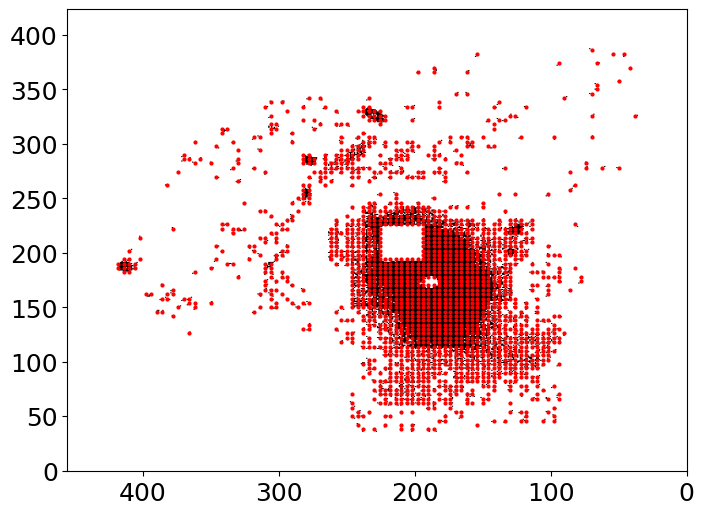

In [286]:
plt.figure(figsize=(8, 6))
plt.imshow(binary_mask, origin='lower', cmap='binary', aspect='auto')
#plt.imshow(rebinned_binary, origin='lower', cmap='binary', aspect='auto')
plt.scatter(x_pts, y_pts, color='red', s=4, label="Bin Centers")
plt.gca().invert_xaxis()  # Match FITS convention
plt.show()

In [287]:
from matplotlib.path import Path

## Define a mask region (here polygon) to only select points that are over the threshold for the actual stream (ie ignore the background and host galaxy)

In [288]:
#select coordinates to include your stream in mask
#change pixel values below to mach your data
polygon_vertices = np.array([
    [345,180],  # (x, y) points
    [325, 180],
    [220, 305],
    [250, 305]
])

In [289]:
polygon_path = Path(polygon_vertices)
xx, yy = np.meshgrid(np.arange(x_size), np.arange(y_size))  # Pixel coordinates
# Flatten and check which points are inside polygon
coords = np.vstack((xx.flatten(), yy.flatten())).T
inside_polygon = polygon_path.contains_points(coords).reshape(binary_mask.shape)

# Apply polygon mask to binary_mask
#binary_mask[~inside_polygon] = 0  # Set pixels outside polygon to 0

bin_coords = np.vstack((x_pts, y_pts)).T
inside_bin_polygon = polygon_path.contains_points(bin_coords)

# Keep only points inside the polygon
x_pts_filtered = x_pts[inside_bin_polygon]
y_pts_filtered = y_pts[inside_bin_polygon]

## Use the red points below and transform to galactocentric frame in your reference system

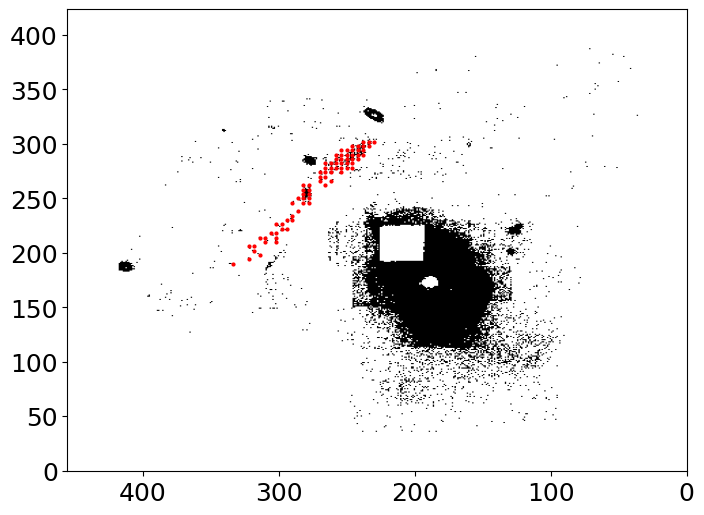

In [290]:
plt.figure(figsize=(8, 6))
#plt.imshow(rebinned_binary , origin='lower', cmap='binary', aspect='auto')
plt.imshow(binary_mask, origin='lower', cmap='binary', aspect='auto')
#plt.scatter(x_pts, y_pts, color='red', s=4, label="Bin Centers")

plt.scatter(x_pts_filtered, y_pts_filtered, color='red', s=4, label="Bin Centers")
#plt.scatter(x_pts, y_pts, color='red', s=4, label="Bin Centers")
plt.gca().invert_xaxis()  # Match FITS convention
plt.show()

In [291]:
#np.max(x_pts)

## Next steps are to transform the red points to the galactocentric frames youd defined for your host galaxy. 

x_pts_filtered, y_pts_filtered are the coordinates you want but you want them first in ra/dec and then in the galactocentric frame of your host galaxy as we discussed reg. astropy

In [292]:
# Convert pixel coordinates to RA/Dec
ra_pts, dec_pts = wcs_helix.all_pix2world(x_pts_filtered, y_pts_filtered, 1)  # 0 = zero-based indexing
#print(ra_pts, dec_pts)

In [293]:
# Convert RA/Dec to ICRS using astropy.coordinates
#from astropy.coordinates import SkyCoord

red_points_icrs_coords = coord.SkyCoord(ra=ra_pts * u.deg, dec=dec_pts * u.deg)# frame='icrs')

In [294]:
# Convert pixel coordinates to RA/Dec for using for xlin , zlin later on for method 
ra_x_pts, dec_y_pts = wcs_helix.all_pix2world(x_pts, y_pts, 1)  # 0 = zero-based indexing

### Sanity check to see if these red points overlap with the stream (did transformation work?)

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_1094170/818302790.py:7: SyntaxWarning: invalid escape sequence '\o'
  plt.colorbar(label='M$_{\odot}$ pc$^{-2}$', shrink=0.75)


Text(401, 28, '30 kpc')

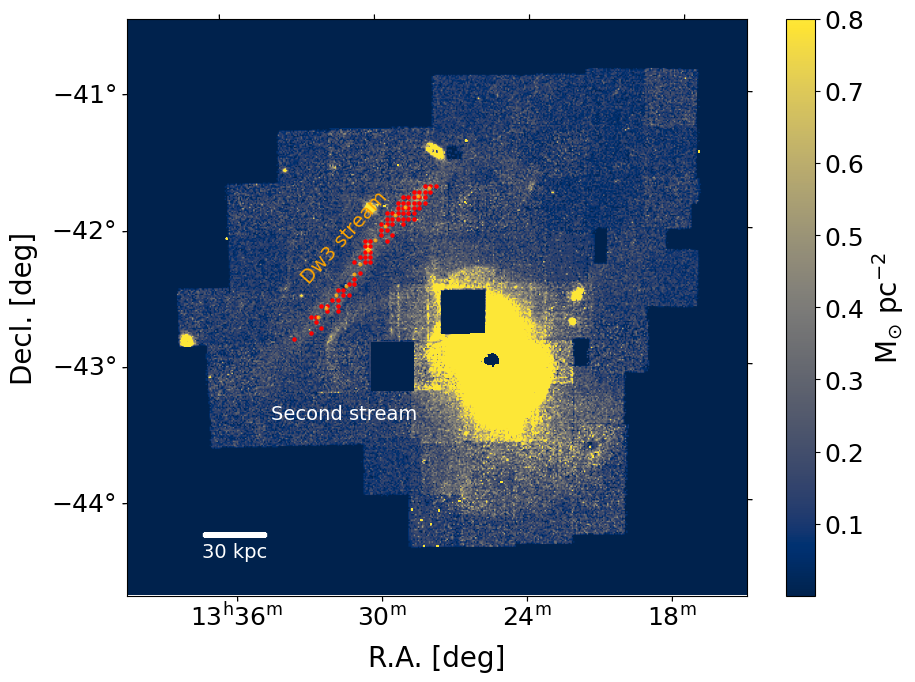

In [295]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_helix)
#plt.imshow(image_fill, origin='lower', cmap='cividis', norm=LogNorm(),vmin =0.01, vmax = 10, aspect='equal', rasterized=True)
plt.imshow(image, origin='lower', cmap='cividis',  aspect='equal', rasterized=True,vmin =0.00001, vmax = 0.8)
plt.xlabel(r'R.A. [deg]')
plt.ylabel(r'Decl. [deg]')
plt.colorbar(label='M$_{\odot}$ pc$^{-2}$', shrink=0.75)



control_points_new = coord.SkyCoord([203.1,\
    202.585167, 202.675, 202.735,202.816, 202.916, 203.016, \
                                 202.515, 202.415, 202.315, 202.215, 202.09,\
                                    201.98]*u.deg, \
                                [-42.68,\
    -42.191741,-42.29,-42.37, -42.45,-42.52,-42.61, \
                                 -42.12, -42.02, -41.94,  -41.88, -41.8,\
                                 -41.74,]*u.deg)


ra_err_new =  np.ones(len(control_points_new.ra.deg))*0.01
dec_err_new =  np.ones(len(control_points_new.dec.deg))*0.01
plt.errorbar(control_points_new.ra.deg, control_points_new.dec.deg,yerr=dec_err_new, xerr=None,\
             fmt='.', color='orange',markersize=4,alpha=0.7,ecolor='white',transform=ax.get_transform('icrs'), rasterized=True)


plt.scatter(red_points_icrs_coords.ra.deg, red_points_icrs_coords.dec.deg, color='red', s=5, transform=ax.get_transform('icrs'))

plt.text(350,130,'Second stream', rotation=0, size=14, color='white', rasterized=True)
plt.text(330,230,'Dw3 stream', rotation=47.76, size=14, color='orange', rasterized=True)

ax.set_ylim([0,424])
ax.set_xlim([456,0])

plt.fill_between([400,354],44,46, color='white', rasterized=True)
plt.text(401,28, '30 kpc', color='white', fontsize=14, rasterized=True)
    
#fig.tight_layout()
#fig.savefig(path + 'CenA2021/plots/Fig1_paper.pdf', dpi=300)


## Then convert ra_pts, dec_pts to galactocentric frame for your host galaxy

In [296]:
#Distance to host
CenA_distance = 3.8 * u.Mpc# 3.8*u.Mpc
#distance to stream progenitor (in your case the same as the host distance)
dw3_distance = 3.88* u.Mpc
#Setting alpha to 0 since we don't need to align stream coordinate system with horizontal axis in this work
alpha = 0*u.deg

In [297]:


#dw3_distance = lnL_input[0]*u.Mpc

#First use distance to define skycoords of Cen A in ICRS
#Cen A skypos
c_CenA = coord.SkyCoord(ra = 201.365063*u.deg, dec =-43.019113*u.deg,\
                    distance = CenA_distance )

# Ans also the Dw3 in ICRS
# dwarf pos

pos = coord.SkyCoord(ra=202.585167*u.deg, dec=-42.191741*u.deg,\
                     distance = dw3_distance)

red_points = coord.SkyCoord(ra=ra_pts *u.deg, dec=dec_pts *u.deg,\
                     distance = dw3_distance)


points_skycoord = coord.SkyCoord(ra=ra_x_pts *u.deg, dec=dec_y_pts *u.deg,\
                     distance = CenA_distance)#wcs_helix.all_pix2world(x_pts, y_pts, 1)  # 0 = zero-based indexing

# Define CenA frame
# Frame to simulate stream in
# Milky Way is along the z-axis x and y axes are 
# oriented with the Cen A stream from Dwarf III
# First need galactocentric frame to simulate stream in
class CenAGalactocentric(coord.BaseCoordinateFrame):
    """
    Position at the center of Cen A

    Milky Way is along the z-axis
    x and y axes are oriented with the Cen A stream from Dwarf III
    
    
    SP checked above, and it seems like it's x and vx that points towards MW
    """

    default_representation = coord.CartesianRepresentation
    default_differential = coord.CartesianDifferential

    # Frame attributes
    CenA_sky_coord = coord.CoordinateAttribute(
        frame=coord.ICRS,
        default=coord.SkyCoord(c_CenA.ra.deg, c_CenA.dec.deg, unit=u.deg)
    )

    CenA_distance = coord.QuantityAttribute(
        default=CenA_distance,# * u.Mpc,
        unit=u.Mpc
    )

    alpha = coord.QuantityAttribute(
        default=alpha,
        unit=u.deg
       
    )

#Don't fully understand if I need the below for the angle, I already do this in the skyoffset frame
from astropy.coordinates.matrix_utilities import rotation_matrix

def get_icrs_to_cena_transform(cena_frame, icrs_frame, inverse=False):
    """
    Get the transformation matrix to go from ICRS to Cen A coordinates.

    Note: Currently this only does positions correctly
    """
   # print(alpha)
    # Rotation matrix to go from CenA to ICRS
    Rz = rotation_matrix(-cena_frame.CenA_sky_coord.ra, 'z')
    Ry = rotation_matrix(cena_frame.CenA_sky_coord.dec, 'y')
    Rx = rotation_matrix(cena_frame.alpha, 'x')
    R = Rz @ Ry @ Rx

    # Positional offset to the center of Cen A (from ICRS)
    dpos = coord.CartesianRepresentation(cena_frame.CenA_distance * [1., 0, 0])

    if inverse:  # Cen A to ICRS
        A = R
        b = (dpos).transform(A)

    else:  # ICRS to Cen A
        A = R.T
        b = -dpos

    return A, b


@coord.frame_transform_graph.transform(
    coord.transformations.AffineTransform,
    coord.ICRS,
    CenAGalactocentric
)
def icrs_to_cena(icrs_coord, cena_frame):
    return get_icrs_to_cena_transform(cena_frame, icrs_coord)


@coord.frame_transform_graph.transform(
    coord.transformations.AffineTransform,
    CenAGalactocentric,
    coord.ICRS
)
def cena_to_icrs(cena_coord, icrs_frame):
    return get_icrs_to_cena_transform(cena_coord, icrs_frame, inverse=True)


# Transform red points to galacticentric frame
red_points_GC = red_points.transform_to(CenAGalactocentric())
# Use CenA Galactocentric frame to get stream progenitor position (one coord should be close to 0 in your case)
dw3_pos_GC = pos.transform_to(CenAGalactocentric())
#sanity check that host galaxy Cen A is at (0,0,0)
c_CenA_GC = c_CenA.transform_to(CenAGalactocentric())

pts_GC = points_skycoord.transform_to(CenAGalactocentric())



In [298]:
# Save dw center in array as you need this info as input for stream fitting method later
# "hack" below to create a coordinate system where the skyplane is in x,z 
# and the perpendicular (line-of-sight, los) directions is along the y axis
dw3_center = np.array([-dw3_pos_GC.y.to(u.kpc).value,dw3_pos_GC.x.to(u.kpc).value, dw3_pos_GC.z.to(u.kpc).value])
# for plotting purposes below (just 0,0,0)
c_CenA_center = np.array([-c_CenA_GC .y.to(u.kpc).value,c_CenA_GC .x.to(u.kpc).value, c_CenA_GC .z.to(u.kpc).value])

Text(0, 0.5, 'z [kpc]')

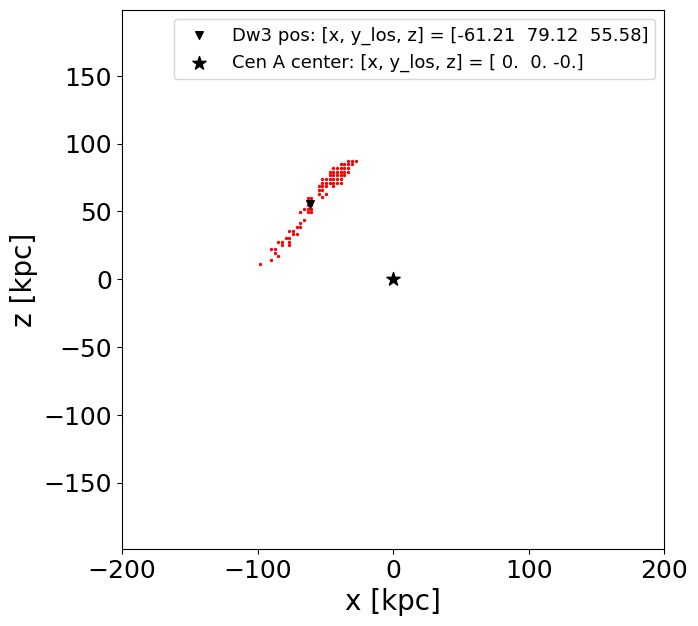

In [299]:
#Visualize red points, stream progenitor and host galaxy in galactocentric coordinate system
plt.figure(figsize=(7,7))
plt.axis('equal') 
# "hack" below to create a coordinate system where the skyplane is in x,z 
# and the perpendicular (line-of-sight, los) directions is along the y axis
plt.scatter(-red_points_GC.y.to(u.kpc), red_points_GC.z.to(u.kpc),  color='red', s=2)#, label="Bin Centers")
plt.scatter(-dw3_pos_GC.y.to(u.kpc), dw3_pos_GC.z.to(u.kpc), marker='v', color='black', s=30, label='Dw3 pos: [x, y_los, z] = ' + str(np.round(dw3_center,2)))
plt.scatter(c_CenA_GC.y,c_CenA_GC.z,marker='*', color='black', s=100, label='Cen A center: [x, y_los, z] = ' + str(np.round(c_CenA_center,2)))

#plt.scatter(-pts_GC.y.to(u.kpc), pts_GC.z.to(u.kpc),  color='black', s=2)

plt.legend(fontsize=13)
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')

In [300]:
#Store the red points in new variable names for method
#These are the input data for the entire metod - important
dat_x = -red_points_GC.y.to(u.kpc).value
dat_z = red_points_GC.z.to(u.kpc).value

#also for progenitor
x_prog = -dw3_pos_GC.y.to(u.kpc).value
y_prog = dw3_pos_GC.x.to(u.kpc).value
z_prog = dw3_pos_GC.z.to(u.kpc).value

## Now use KL-divergence extragalactic stream fitting method.

This uses the streamsculpture package to fit and generate streams on Jax 

In [301]:
import streamsculptor
from streamsculptor import  potential
from streamsculptor import fields
from streamsculptor import JaxCoords as jc
import diffrax
from jax.scipy.stats import gaussian_kde
import jax
import equinox as eqx
jax.config.update("jax_enable_x64", True)


from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp


# import matplotlib.pyplot as plt
# import numpy as np
# import astropy.coordinates as coord
# from astropy.coordinates import SkyCoord

import gala.coordinates as gc

from functools import partial
from gala.units import galactic

import tqdm
#import scienceplots
import matplotlib as mpl
#plt.style.use('science')
mpl.rcParams['text.usetex'] = False ## We do not have LaTex on stellar HPC...
from astropy.constants import G as G_
#import tqdm
G_jax = jnp.array(G_.to(u.kpc**3 / (u.Msun * u.Myr**2)).value)

from scipy.interpolate import UnivariateSpline
#from scipy.integrate import cumtrapz

from jax import random

In [302]:
# Select which GPU you want on astro 01
jax.default_device('CudaDevice(id=2)')

In [303]:
#Check that you're running on GPU
# Check that Jax works  on GPU - should print GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [304]:
# To resolve potential well enough we need the general_nfw_interp.npy file from Jake (ask Sarah for this )
interp_func = jnp.load('general_nfw_interp.npy',allow_pickle=True).item()
@jax.jit
def generalized_nfw_potential(xyz, t, params):
    r = jnp.sqrt(jnp.sum(xyz**2)) 
    r_over_r_s = r/params['r_s']
    bracket = interp_func(r_over_r_s,params['gamma'],params['beta'])*(params['r_s']**2)
    return -4*jnp.pi*G_jax*bracket*params['rho0']


params = dict(gamma=1.0,beta=3, r_s=10.0, rho0=1e7)

In [305]:
#check that it works
generalized_nfw_potential(jnp.array([1.0,2.0,3.0]),0.0, params)

Array(-0.04455536, dtype=float64)

In [306]:
from streamsculptor.potential import CustomPotential
def get_general_NFW_potential(params):
    pot = lambda xyz, t: generalized_nfw_potential(xyz, t, params)
    return CustomPotential(potential_func=pot, units=usys)

In [307]:
params = dict(gamma=1.4,beta=3, r_s=10.0, rho0=1e7)
get_general_NFW_potential(params).potential(jnp.array([1.0,2.0,3.0]),0.0)

Array(-0.06174879, dtype=float64)

In [308]:
@jax.jit
def get_nfw_rho0(M,r_s):
    c_NFW = 15. # following https://arxiv.org/pdf/2211.04495
    denom = jnp.log(1. + c_NFW) - (c_NFW/(1+c_NFW))
    fac = 1./denom
    rho0 = (M/(4*jnp.pi*r_s**3))*fac
    return rho0
np.log10(get_nfw_rho0(3e12,22.))

7.086986282014672

In [309]:
from streamsculptor.potential import MiyamotoNagaiDisk
from streamsculptor import potential

In [310]:
# Define potential with halo and disk

def get_potential(params):
    pot_disk =  MiyamotoNagaiDisk(m=params['m_disk'], a=params['a_disk'],
                                       b=params['b_disk'],units=usys)
    rho0 = get_nfw_rho0(params['M'],params['r_s'])
    
    pot_halo = get_general_NFW_potential(dict(rho0=rho0, gamma=params['gamma'], beta=params['beta'],
                                              r_s=params['r_s']))
    
    
    potential_list = [pot_disk,pot_halo]
    pot = potential.Potential_Combine(potential_list=potential_list,units=usys)
    return pot


# write stream generating function which we'll use later    

@partial(jax.jit,static_argnums=(15,))
def gen_stream(x_prog=None, 
               y_prog=None, 
               z_prog=None, 
               log10_M_prog=None, 
               speed=None, 
               vel_theta=None, 
               vel_phi=None, 
               log10_m_disk=None, 
               a_disk=None,
               b_disk=None, 
               log10_m_halo=None, 
               r_s=None, 
               gamma=None, 
               beta=None, 
               t_age=None, 
               N_arm=None,
               #SP what does this offset below mean? 
               offset=jnp.array([-40,0.0,140.0,0.0,0.0,0.0])):
    """
    x and z is sky plane, y is LOS
    xyz_prog is the progenitor position today in these coords
    speed is the total speed of the prog.
    vel_theta controls the spherical polar direction of the unit velocity vector [0,pi]
    vel_phi controls the azimuthal direction of the unit velocity vector [0,2pi]
    """
    params = {'m_disk':10**log10_m_disk, 'a_disk': a_disk, 'b_disk': b_disk, 'M': 10**log10_m_halo,
                          'r_s': r_s, 'gamma': gamma, 'beta':beta, 't_age':t_age}
    pot = get_potential(params)
    v_x_hat = jnp.sin(vel_theta)*jnp.cos(vel_phi)
    v_y_hat = jnp.cos(vel_theta) #SP moved
    v_z_hat = jnp.sin(vel_theta)*jnp.sin(vel_phi)
    velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*speed
    

    pos_today = jnp.array([x_prog, y_prog, z_prog])
    w_today = jnp.hstack([pos_today, velocity_today])
    
    ts = jnp.linspace(-t_age,0,N_arm) #4_000


    w_init = pot.integrate_orbit(w0=w_today, t0=0.0, t1=-t_age, ts=jnp.array([-t_age]),
                                solver=diffrax.Tsit5(),atol=1e-6, rtol=1e-6,dtmin=0.5,max_steps=20_000).ys[0]


    ## Now generate a mock stream along the above orbit
    Msat = 10**log10_M_prog #progenitor mass
    seed = 4031
    kval_arr=jnp.array([1.3,0.0,0.0,0.0,.5,.5,.6,0.0])
    lead_arm, trail_arm = pot.gen_stream_vmapped(prog_w0=w_init, ts=ts, Msat=Msat, seed_num=seed,
                                                solver=diffrax.Tsit5(),atol=1e-6, rtol=1e-6,dtmin=0.5,
                                                kval_arr=kval_arr, max_steps=20_000)
    stream = jnp.vstack([lead_arm,trail_arm])
    return dict(w_today=w_today, stream=stream, stripping_times=jnp.hstack([ts, ts]))


In [311]:
np.max(-pts_GC.y.to(u.kpc).value)

100.07656659564157

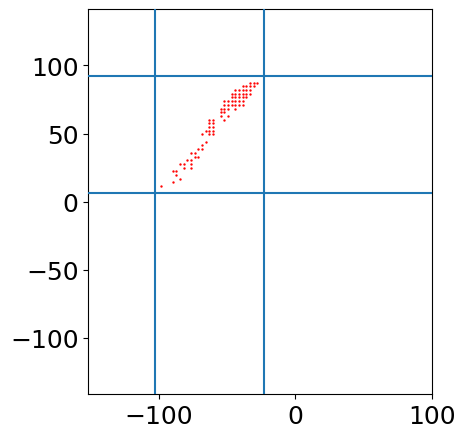

In [312]:
# Generate boundry around stream points to not penalize streams that are too long (method  disgards these)
#SP now looking at the outer stream only, so selecting H_proj1_out and xlin_outer,zlin_outer
#from now on the coordinates are correct in x,z as plane of sky

#dat_inner = jnp.vstack([xpts_inner, zpts_inner]).T
# drawing bounds to not penalize stream from being longer than control points dictate 
pad = 5. 
xbounds = jnp.array([dat_x.min()-pad, dat_x.max()+pad])
zbounds = jnp.array([dat_z.min()-pad, dat_z.max()+pad])


# #dat_outer = jnp.vstack([xpts, zpts]).T


fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,5)

#ax.pcolormesh(xlin_outer,zlin_outer,H_proj1_outer,cmap='binary')
ax.scatter(dat_x,dat_z,color='r',s=.5)
#ax.scatter(outer_stream_dict['stream'][:,0],outer_stream_dict['stream'][:,2],s=0.06,color='g',zorder=3,)

# Need to base these off of the grid we made with bin_factor 
# but that was in pixels.... base this off of x_pts y_pts as they span the space but in pixels.
#below is important for method so come back to this. Should now be spanned from the correct bin range and size from bin factor setting the x_center.shape param
xlin = jnp.linspace(np.min(-pts_GC.y.to(u.kpc).value),np.max(-pts_GC.y.to(u.kpc).value),x_centers.shape[0])
zlin = jnp.linspace(np.min(-pts_GC.z.to(u.kpc).value),np.max(pts_GC.z.to(u.kpc).value),x_centers.shape[0])
ax.set_xlim(xlin.min(), xlin.max())
ax.set_ylim(zlin.min(),zlin.max())


ax.vlines(xbounds[0],-1e5,1e5,zorder=50)
ax.vlines(xbounds[1],-1e5,1e5,zorder=50)
ax.hlines(zbounds[0],-1e5,1e5,zorder=50)
ax.hlines(zbounds[1],-1e5,1e5,zorder=50)

ax.set_aspect('equal')




In [313]:
xlin.shape

(114,)

In [314]:
# We need these for method, and it needs to be the correct binning. 
X, Z = jnp.meshgrid(xlin,zlin)
x_eval, z_eval = X.flatten(), Z.flatten()


In [315]:
#SP now we need to make kde for method to compare to, KDE from control points

@jax.jit
def regional_weight_func(xloc, zloc, xbounds, zbounds,scale_fac=.5):
    arg=( (xloc - jnp.mean(xbounds)) / (scale_fac*(xbounds[1]-xbounds[0])) )**2 + ( (zloc - jnp.mean(zbounds)) / (scale_fac*(zbounds[1]-zbounds[0])) )**2
    return jnp.exp(-0.5*arg)
   
regional_weight_func(-29.,120.,xbounds,zbounds)

mapped_weight_func = jax.vmap(regional_weight_func,in_axes=(0,0,None,None,None))

In [316]:
jax.jacfwd(regional_weight_func,argnums=(0,1,))(21.,120.,xbounds,zbounds,.5)

(Array(-0.00151725, dtype=float64), Array(-0.00111943, dtype=float64))

In [317]:
@jax.jit
def kde_fit_and_eval(x_stream, z_stream, x_eval, z_eval,bw=.1):
    in_bounds = (x_stream > xbounds[0]) & (x_stream < xbounds[1]) & (z_stream > zbounds[0]) & (z_stream < zbounds[1])
    weights_init = jnp.where(in_bounds, 1.0, 0.0)
    inp = jnp.vstack([x_stream, z_stream])
    inp_eval = jnp.vstack([x_eval, z_eval])
    #bw = .1 #was .15
    denom = gaussian_kde(inp,bw_method=bw,weights=weights_init).pdf(inp)
    weights = jnp.where(in_bounds, 1./denom, 0.0)
    weights = weights/weights.sum()
    
    pdf = gaussian_kde(inp,bw_method=bw,weights=weights).pdf(inp_eval)
    return pdf
    
    
    
@jax.jit
def kde_fit_and_log_eval(x_stream, z_stream, x_eval, z_eval,bw=.1): #.1
    in_bounds = (x_stream > xbounds[0]) & (x_stream < xbounds[1]) & (z_stream > zbounds[0]) & (z_stream < zbounds[1])
    weights_init = jnp.where(in_bounds, 1.0, 0.0)
    inp = jnp.vstack([x_stream, z_stream])
    inp_eval = jnp.vstack([x_eval, z_eval])
    #bw = .1 #was .15
    denom = gaussian_kde(inp,bw_method=bw,weights=weights_init).pdf(inp)
    weights = jnp.where(in_bounds, 1./denom, 0.0)
    weights = weights/weights.sum()
    logpdf_vals =  gaussian_kde(inp,bw_method=bw,weights=weights).logpdf(inp_eval)
    return logpdf_vals#jnp.where(jnp.isnan(logpdf_vals), jnp.inf, logpdf_vals)

    
    

In [318]:
#SP uncommented, since we don't use this in inference loop and it reads in Jake's test strem which we don't have 
def eval_log_pdf(params_constrain, params_fix):
    params_gen_stream = {**params_constrain, **params_fix}
    stream_dict = gen_stream(**params_gen_stream)
    log_pdata = kde_fit_and_log_eval(stream_dict['stream'][:,0],stream_dict['stream'][:,2], dat_outer[:,0],dat_outer[:,1]) #already in x,z coords 
    return log_pdata, stream_dict['stream']



In [319]:
x_prog

-61.21157363445118

In [ ]:
# true params: we don't know all
# Sp below are the true params for the corner plot
# To find true params in correct units for cornerplot:
#Pos today 

pos_today_true = jnp.array([x_prog, y_prog, z_prog])
print('pos_today [x, y (los), z]')
print(pos_today_true)
print('')
#vel today - we don't know these so setting abitrary for now
vx_today = 0.001 # we don;t know
vy_today = 0.001 # we don;t know
vz_today = 0.001 # we don;t know
vel_today =  jnp.array([vx_today, vy_today, vz_today])
print('vel_today  [vx, vlos, vz]')
print(vel_today)
print('')
v_mag = (vx_today**2 + vy_today**2 + vz_today**2)**0.5
print('v_mag')
print(v_mag)
print('')
vx_hat_today = vx_today / v_mag
vy_hat_today = vy_today / v_mag
vz_hat_today = vz_today / v_mag
v_hat_today = jnp.array([vx_hat_today , vy_hat_today , vz_hat_today ])
print('v_hat')
print(v_hat_today)
print('')
speed = v_mag*(u.km/u.s).to(u.kpc/u.Myr)
print('speed')
print(speed)
print('')
#sanity check that below is same as vz_hat
#jnp.sqrt(1.0 - vx_hat**2 -vy_hat**2)*pm

theta_today = jnp.arccos(vy_hat_today) #this should be our perpendicular to plane angle! y is here los. 
phi_today_test = jnp.arctan2(vz_today, vx_today) #between -pi to pi. 
#  Shift the range to 0 <= phi < 2*pi (by adding pi)
phi_today_shifted = phi_today_test + jnp.pi
#  Ensure phi is within 0 <= phi < 2*pi (by taking modulo 2*pi)
phi_today = jnp.mod(phi_today_shifted, 2 * jnp.pi)

#if phi_today < 0:
 #   phi_today = phi_today + 2*jnp.pi
print('phi,theta')
print(phi_today, theta_today )
#also need to find phi, theta of today...



pos_today [x, y (los), z]
[-61.21157363  79.11894428  55.58200622]

vel_today  [vx, vlos, vz]
[0.001 0.001 0.001]

v_mag
0.0017320508075688774

v_hat
[0.57735027 0.57735027 0.57735027]

speed
1.7713894313779111e-06

phi,theta
3.9269908169872414 0.9553166181245093


In [387]:
# SP adding these values for the truth below for the observed stream which we know only know some info for 
outer_stream_prog0 = dict(x_prog=x_prog,y_prog=y_prog,z_prog=z_prog,speed = speed,vel_theta=theta_today,vel_phi=phi_today, log10_M_prog=7.3,
                        log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=12.0,r_s=8.1497,gamma=0.8853,beta=3.674,
                         t_age=2000., N_arm=4_000 )


In [382]:
#these are the variables we're trying to constrain
params_constrain_names = ['y_prog', 'speed', 'vel_theta', 'vel_phi', 'log10_M_prog',
                    'log10_m_halo', 'r_s', 'gamma', 'beta', 't_age']
#these are also input to the method but we fix these based on observational data                     
params_fix_names = ['x_prog','z_prog','log10_m_disk','a_disk','b_disk','N_arm']


#we don't know true params in our case of data
constrained_values_truth = {key: jnp.array(outer_stream_prog0[key]) for key in params_constrain_names}
fixed_values_truth =  {key: jnp.array(outer_stream_prog0[key]) for key in params_fix_names}
fixed_values_truth['N_arm'] = 500# 600, 800

#SP uncommented below
log_pdf_master = lambda params_constrain: eval_log_pdf(params_constrain, fixed_values_truth)[0]
log_pdf_master = jax.jit(log_pdf_master)


#out = log_pdf_master(constrained_values_truth)

In [323]:
@jax.jit
def get_prog_coords(params_constrain, params_fix=fixed_values_truth):
    params_tot = {**params_constrain, **fixed_values_truth}
    vel_theta = params_tot['vel_theta']
    vel_phi = params_tot['vel_phi']
    speed = params_tot['speed']
    x_prog = params_tot['x_prog']
    y_prog = params_tot['y_prog']
    z_prog = params_tot['z_prog']
    
    v_x_hat = jnp.sin(vel_theta)*jnp.cos(vel_phi)
    v_y_hat = jnp.cos(vel_theta) #sp swapped below here.
    v_z_hat = jnp.sin(vel_theta)*jnp.sin(vel_phi)
    velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*speed
    

    pos_today = jnp.array([x_prog, y_prog, z_prog])
    w_today = jnp.hstack([pos_today, velocity_today])
    
    return w_today
    

In [324]:
@jax.jit
def compute_nrg_prog(w_today, params_pot_constrain):
    pot_params_total = dict(M=10**params_pot_constrain['log10_m_halo'], 
                            r_s=params_pot_constrain['r_s'], 
                            gamma=params_pot_constrain['gamma'],
                            beta=params_pot_constrain['beta'], 
                            m_disk=10**fixed_values_truth['log10_m_disk'], 
                            a_disk=fixed_values_truth['a_disk'], 
                            b_disk=fixed_values_truth['b_disk'])
    pot_curr = get_potential(pot_params_total)
    
    nrg_prog = pot_curr.potential(w_today[:3],0.0) + 0.5*jnp.sum(w_today[3:]**2)
    return nrg_prog
    
@jax.jit
def evaluate_cost_no_prior(params_constrain, N_data):
    
    w_today = get_prog_coords(params_constrain)
    nrg = compute_nrg_prog(w_today, params_constrain)
    bound_bool = nrg < 0.0
    
    def true_func():
        """
        If the progenitor is bound, produce a stream and compute the test-statistic
        """
        log_PDF = log_pdf_master(params_constrain)
        inter_sum = (1./N_data)*( jnp.log((1./N_data)) - log_PDF )
        neg_KL = -jnp.sum(inter_sum)
        neg_KL = jnp.where( jnp.isnan(neg_KL), -jnp.inf, neg_KL)
        return neg_KL ### maximizie this (it's just the evidence lower bound)
    
    def false_func():
        """
        If the progenitor is unbound, return -inf, thereby rejecting the sample
        """
        return -jnp.inf
    
    return jax.lax.cond(bound_bool, true_func, false_func)


map_dict_names = {key: 0 for key in params_constrain_names}

@jax.jit    
def vectorized_cost(params, N_data):
    mapped_func = jax.vmap(evaluate_cost_no_prior,in_axes=(map_dict_names,None,))
    return mapped_func(params, N_data)


In [388]:
constrained_values_truth

{'y_prog': Array(79.11894428, dtype=float64),
 'speed': Array(1.02271217e-06, dtype=float64, weak_type=True),
 'vel_theta': Array(1.57079633, dtype=float64, weak_type=True),
 'vel_phi': Array(3.14159265, dtype=float64, weak_type=True),
 'log10_M_prog': Array(8.5, dtype=float64, weak_type=True),
 'log10_m_halo': Array(12., dtype=float64, weak_type=True),
 'r_s': Array(8.1497, dtype=float64, weak_type=True),
 'gamma': Array(0.8853, dtype=float64, weak_type=True),
 'beta': Array(3.674, dtype=float64, weak_type=True),
 't_age': Array(2000., dtype=float64, weak_type=True)}

In [389]:
fixed_values_truth

{'x_prog': Array(-61.21157363, dtype=float64),
 'z_prog': Array(55.58200622, dtype=float64),
 'log10_m_disk': Array(10.69897, dtype=float64),
 'a_disk': Array(3., dtype=float64, weak_type=True),
 'b_disk': Array(0.2, dtype=float64, weak_type=True),
 'N_arm': 500}

In [327]:
@jax.jit
def get_prog_coords(params_constrain, params_fix=fixed_values_truth):
    params_tot = {**params_constrain, **fixed_values_truth}
    vel_theta = params_tot['vel_theta']
    vel_phi = params_tot['vel_phi']
    speed = params_tot['speed']
    x_prog = params_tot['x_prog']
    y_prog = params_tot['y_prog']
    z_prog = params_tot['z_prog']
    
    v_x_hat = jnp.sin(vel_theta)*jnp.cos(vel_phi)
    v_y_hat = jnp.cos(vel_theta) #sp swapped below here.
    v_z_hat = jnp.sin(vel_theta)*jnp.sin(vel_phi)
    velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*speed
    

    pos_today = jnp.array([x_prog, y_prog, z_prog])
    w_today = jnp.hstack([pos_today, velocity_today])
    
    return w_today
    

In [328]:
@jax.jit
def compute_nrg_prog(w_today, params_pot_constrain):
    pot_params_total = dict(M=10**params_pot_constrain['log10_m_halo'], 
                            r_s=params_pot_constrain['r_s'], 
                            gamma=params_pot_constrain['gamma'],
                            beta=params_pot_constrain['beta'], 
                            m_disk=10**fixed_values_truth['log10_m_disk'], 
                            a_disk=fixed_values_truth['a_disk'], 
                            b_disk=fixed_values_truth['b_disk'])
    pot_curr = get_potential(pot_params_total)
    
    nrg_prog = pot_curr.potential(w_today[:3],0.0) + 0.5*jnp.sum(w_today[3:]**2)
    return nrg_prog
    
@jax.jit
def evaluate_cost_no_prior(params_constrain, N_data):
    
    w_today = get_prog_coords(params_constrain)
    nrg = compute_nrg_prog(w_today, params_constrain)
    bound_bool = nrg < 0.0
    
    def true_func():
        """
        If the progenitor is bound, produce a stream and compute the test-statistic
        """
        log_PDF = log_pdf_master(params_constrain)
        inter_sum = (1./N_data)*( jnp.log((1./N_data)) - log_PDF )
        neg_KL = -jnp.sum(inter_sum)
        neg_KL = jnp.where( jnp.isnan(neg_KL), -jnp.inf, neg_KL)
        return neg_KL ### maximizie this (it's just the evidence lower bound)
    
    def false_func():
        """
        If the progenitor is unbound, return -inf, thereby rejecting the sample
        """
        return -jnp.inf
    
    return jax.lax.cond(bound_bool, true_func, false_func)


map_dict_names = {key: 0 for key in params_constrain_names}

@jax.jit    
def vectorized_cost(params, N_data):
    mapped_func = jax.vmap(evaluate_cost_no_prior,in_axes=(map_dict_names,None,))
    return mapped_func(params, N_data)


-2.104474337904599


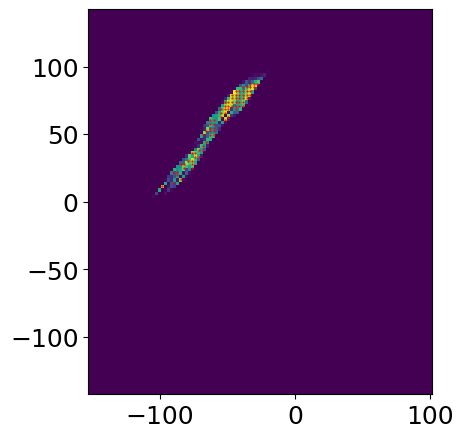

In [331]:
N_data = len(dat_x)
bw_red = .1455#.16
# Fit KDE to control points, and evaluate at constrol points [todo, bandwidth optimization?]
log_p_thresh = kde_fit_and_log_eval(dat_x, dat_z, dat_x, dat_z,bw=bw_red)
inter_sum_thresh = (1./N_data)*( jnp.log((1./N_data)) - log_p_thresh )
neg_KL_thresh = -jnp.sum(inter_sum_thresh)
print(neg_KL_thresh)
pdf_out_thresh = kde_fit_and_eval(dat_x, dat_z, x_eval, z_eval, bw=bw_red).reshape(X.shape)

#sanity check if the whole x_lin z_lin binning worked 
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,5)
ax.pcolormesh(X, Z, pdf_out_thresh)
ax.scatter(dat_x,dat_z,color='r',s=.3)

ax.set_aspect('equal')



In [332]:
# now define your priors for the free input params
from nautilus import Prior
from nautilus import Sampler


prior = Prior()

prior.add_parameter('y_prog', dist=(-120.,120.))
prior.add_parameter('speed', dist=(0.05,0.4))#(100.,250.)) #in kpc/Myr
prior.add_parameter('vel_theta', dist=(0., jnp.pi))
prior.add_parameter('vel_phi', dist=(0., 2. * jnp.pi))
prior.add_parameter('log10_M_prog', dist=( 7.0,9.5))
prior.add_parameter('log10_m_halo', dist=( 11.0,13.0))
prior.add_parameter('r_s', dist=( 5.,15.))
prior.add_parameter('gamma', dist=( 0.,2.)) #fixed within this range
prior.add_parameter('beta', dist=( 2.,4.)) #fixed within this range
prior.add_parameter('t_age', dist=( 1_000.,4_500.))




cost_naut = lambda params: vectorized_cost(params, N_data)




In [333]:
sampler = Sampler(prior, cost_naut, n_live=1000,vectorized=True,n_batch=500) #500, 500
sampler.run(verbose=True, n_eff=15_000,f_live=0.0001)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    


KeyboardInterrupt: 

In [334]:
# Visualize corner plot
points, log_w, log_l = sampler.posterior(equal_weight=False)
points.shape, 



((50500, 10),)

In [390]:
true_params = jnp.array([constrained_values_truth['y_prog'], 
                        constrained_values_truth['speed'],
                        constrained_values_truth['vel_theta'],
                        constrained_values_truth['vel_phi'],
                        constrained_values_truth['log10_M_prog'],
                        constrained_values_truth['log10_m_halo'],
                        constrained_values_truth['r_s'],
                         constrained_values_truth['gamma'],
                         constrained_values_truth['beta'],
                         constrained_values_truth['t_age']
                        ])

true_params.shape

(10,)

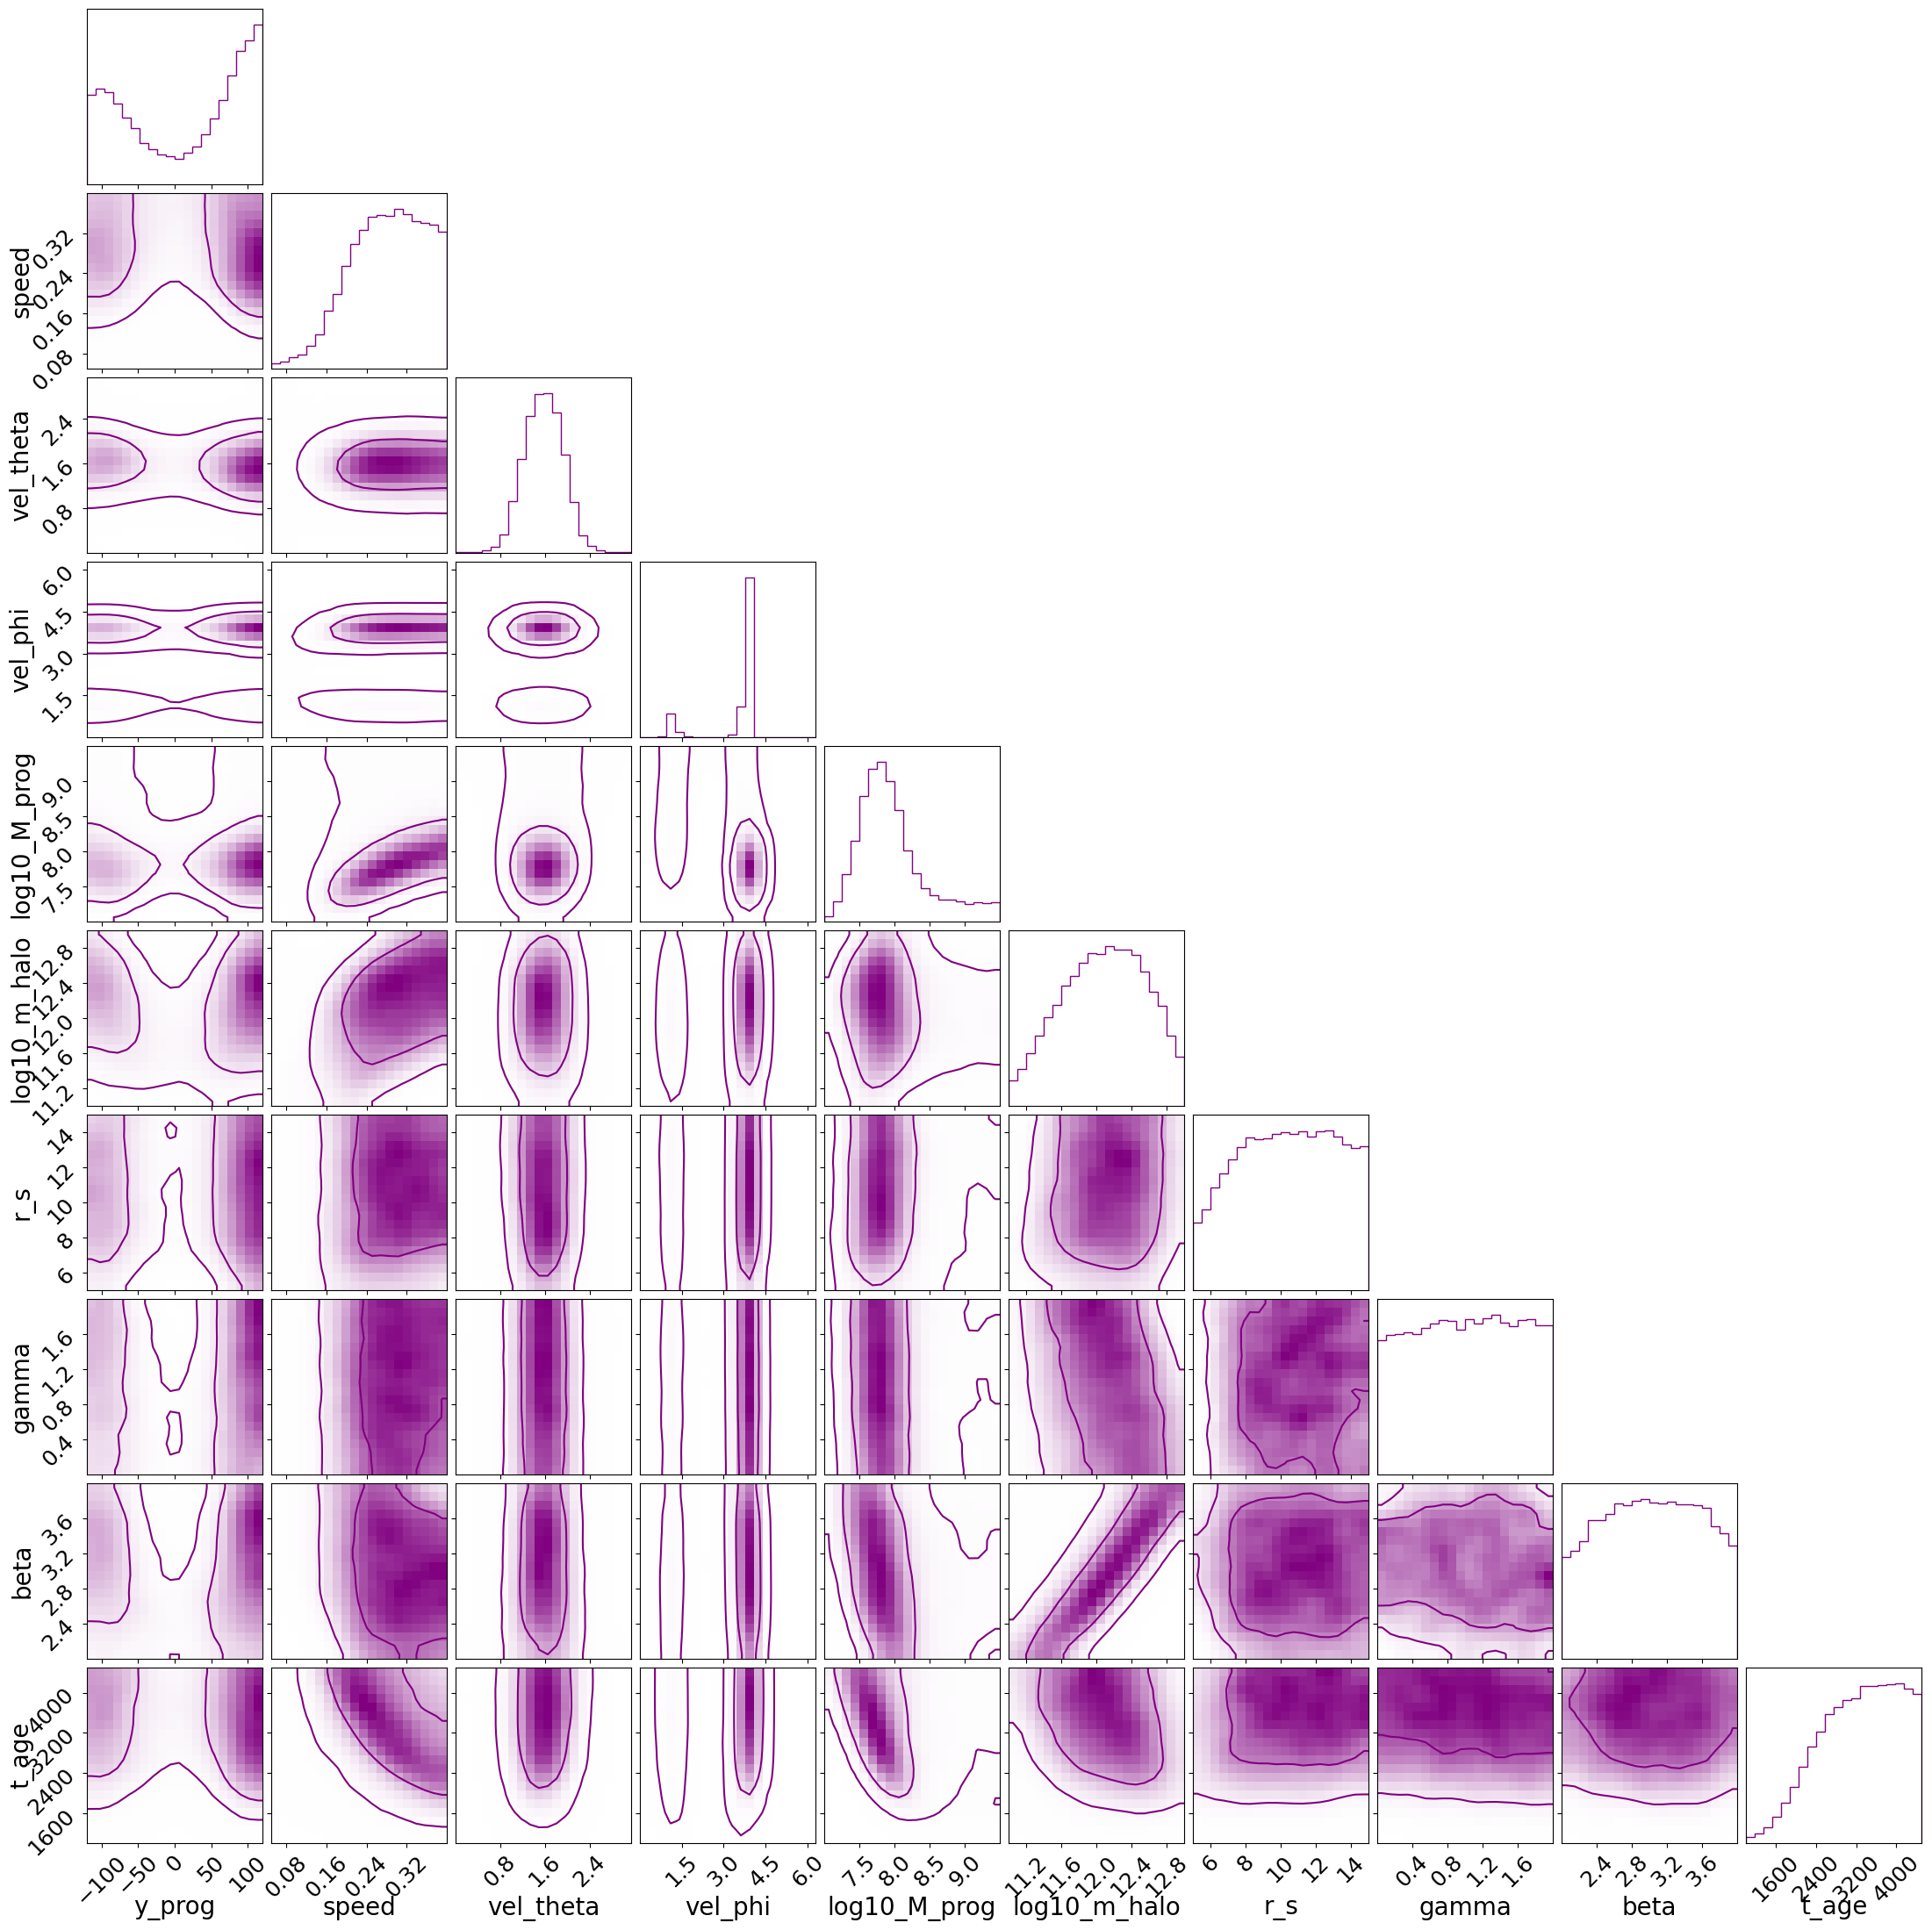

In [392]:
import corner
corner.corner(
    points, weights=np.exp(log_l-log_l.max()), bins=20, labels=prior.keys, color='purple',
    plot_datapoints=False,levels=(0.68,0.95),#truths=true_params,
smooth=1.);

# Now plot stream within contours

In [371]:
y_prog_fit = 100 # kpc
speed_fit = 0.24
vel_theta_fit = 1.6
vel_phi_fit=3.9
log10_M_prog_fit=7.5

stream_prog1 = dict(x_prog=x_prog,y_prog=y_prog_fit ,z_prog=z_prog,speed=speed_fit,vel_theta=vel_theta_fit,vel_phi=vel_phi_fit, log10_M_prog=log10_M_prog_fit,
                        log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=12.0,r_s=10.0,gamma=0.8853,beta=3.674,
                         t_age=3500., N_arm=4_000) #4_000


In [372]:
stream_dict = gen_stream(**stream_prog1)


In [373]:
v_x_hat = jnp.sin(vel_theta_fit)*jnp.cos(vel_phi_fit)
v_y_hat = jnp.cos(vel_theta_fit) #SP moved
v_z_hat = jnp.sin(vel_theta_fit)*jnp.sin(vel_phi_fit)
velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*speed_fit
velocity_today*(u.kpc/u.Myr).to(u.km/u.s)

pos_today_fit = np.array([x_prog,y_prog_fit, z_prog  ])

Text(0, 0.5, 'z [kpc]')

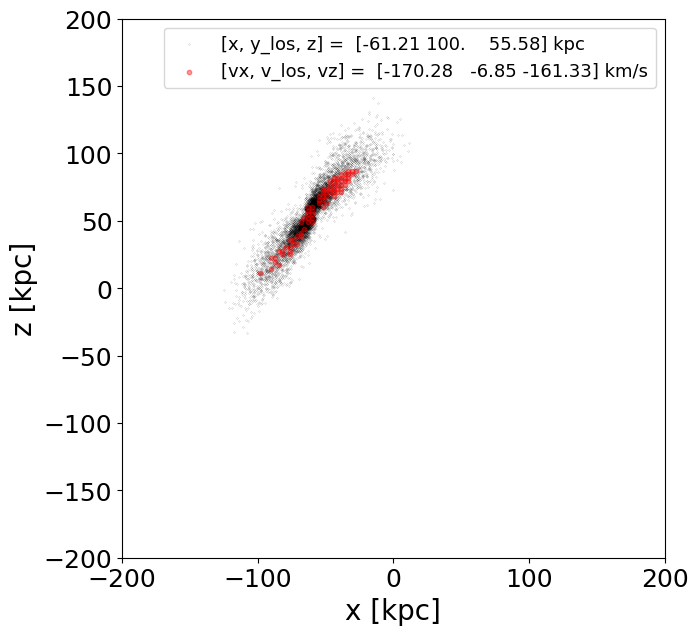

In [376]:
plt.figure(figsize=(7,7))
plt.scatter(stream_dict['stream'][:,0],stream_dict['stream'][:,2],s=0.006,color='k',label='[x, y_los, z] =  '+ str(np.round(pos_today_fit,2)) + ' kpc')
#plt.scatter(outer_stream_NFW[:,0],outer_stream_NFW[:,2],s=.5)
#plt.hist2d(pos[:,0], pos[:,1], bins=np.linspace(-300,300,800),  cmap = histcolor,norm=LogNorm());
#plt.scatter(x_center_outer1,y_center_outer1, marker='*', s=100, color=color_prog[0], alpha=1, label ='vr = ' + str(np.round(binned_velocities_o1[prog_outer1_index],1)) + ' km/s')
#plt.scatter(dat_inner[:,0], dat_inner[:,1], s=2, alpha = 0.4)
plt.scatter(dat_x, dat_z, s=10, alpha = 0.4, color='red' , label='[vx, v_los, vz] =  '+ str(np.round(velocity_today*(u.kpc/u.Myr).to(u.km/u.s),2) )+ ' km/s')
plt.xlim([-200,200])
plt.ylim([-200,200])
plt.xlabel('x [kpc]')
plt.legend(fontsize=13)
plt.ylabel('z [kpc]')
#plt.savefig()